## LSTM

/tmp/ipython-input-2-3726576995.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Epoch [1/100], Training Loss (LSTM): 0.6276
Epoch [1/100], Validation Loss (LSTM): 0.3985
Epoch [1/100], Test Loss (LSTM): 3.3888
Epoch [2/100], Training Loss (LSTM): 0.6206
Epoch [2/100], Validation Loss (LSTM): 0.4018
Epoch [2/100], Test Loss (LSTM): 3.3937
Epoch [3/100], Training Loss (LSTM): 0.6138
Epoch [3/100], Validation Loss (LSTM): 0.4052
Epoch [3/100], Test Loss (LSTM): 3.3986
Epoch [4/100], Training Loss (LSTM): 0.6072
Epoch [4/100], Validation Loss (LSTM): 0.4086
Epoch [4/100], Test Loss (LSTM): 3.4035
Epoch [5/100], Training Loss (LSTM): 0.6005
Epoch [5/100], Validation Loss (LSTM): 0.4120
Epoch [5/100], Test Loss (LSTM): 3.4083
Epoch [6/100], Training Loss (LSTM): 0.5940
Epoch [6/100], Validation Loss (LSTM): 0.4155
Epoch [6/100], Test Loss (LSTM): 3.4128
Epoch [7/100], Training Loss (LSTM): 0.5874
Epoch [7/100], Validation Loss (LSTM): 0.4189
Epoch [7/100], Test Loss (LSTM): 3.4172
Epoch [8/100], Training Loss (LSTM): 0.5809
Epoch [8/100], Validation Loss (LSTM): 0.4224


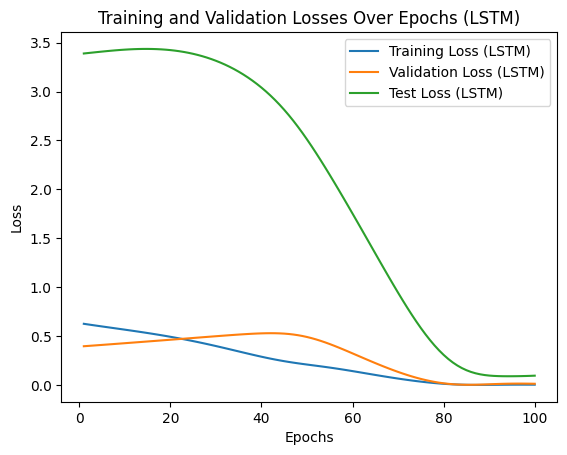

Validation Set Metrics (LSTM):
Mean Absolute Error (MAE): 0.0912
Mean Squared Error (MSE): 0.0152
Root Mean Squared Error (RMSE): 0.1231
Mean Absolute Percentage Error (MAPE): 79.2399

Test Set Metrics (LSTM):
Mean Absolute Error (MAE): 0.1843
Mean Squared Error (MSE): 0.0977
Root Mean Squared Error (RMSE): 0.3126
Mean Absolute Percentage Error (MAPE): 13.0490


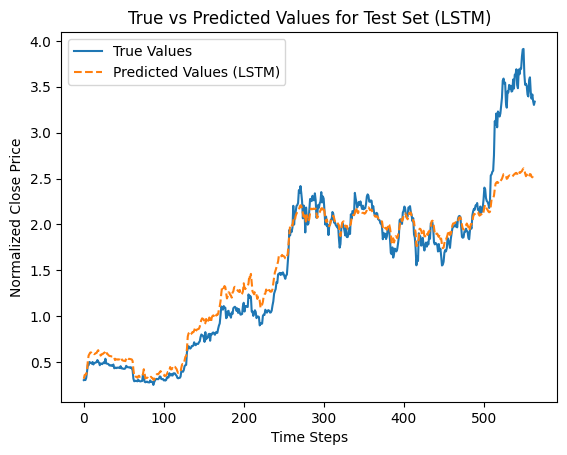

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the stock symbol and date range
stock_symbol = "BTC-USD"
start_date = "2013-01-01"
end_date = "2025-01-01"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset index to make 'Date' a column again
stock_data.reset_index(inplace=True)

# Use 'Date' as index
stock_data.set_index('Date', inplace=True)

# Normalize data
columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close']
data_to_normalize = stock_data[columns_to_normalize].values

# Convert the data to PyTorch tensor
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)

# Calculate mean and standard deviation for each column
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)

# Normalize the data
normalized_data = (tensor_data - mean) / std

# Convert the normalized data back to a DataFrame
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)

# Add 'Date' column back to the DataFrame
df_normalized['Date'] = stock_data.index
data = df_normalized

# Define the percentage of data for training, validation, and testing
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

# Calculate the sizes of the train, validation, and test sets
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

# Split the data into train, validation, and test sets
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

# Define the features(inputs) and target columns
feature_columns = ['Low', 'Open', 'High']
target_column = 'Close'

# Extract features and target for each dataset
train_features = train_data[feature_columns].values
train_target = train_data[target_column].values

val_features = val_data[feature_columns].values
val_target = val_data[target_column].values

test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

# Convert data to PyTorch tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

num_epochs= 100



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, cn) = self.lstm(x)  # Use both hidden state (hn) and cell state (cn)
        x = self.fc_output(hn[-1, :, :])
        return x



# Define hyperparameters for LSTM
hidden_size_lstm = 64
num_layers_lstm = 2

# Define hyperparameters
input_size = len(feature_columns)
hidden_size = 64
output_size = 1
num_layers = 2
num_attention_heads = 4
learning_rate = 0.001
num_epochs = 100
# Define the number of time steps to use as input features
num_time_steps = 10

# Create the LSTM model instance
model_lstm = LSTMModel(input_size, hidden_size_lstm, output_size, num_layers_lstm)

# Define the loss function and optimizer for LSTM
criterion= nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)

# Lists to store training, validation, and test losses for LSTM
train_losses_lstm = []
val_losses_lstm = []
test_losses_lstm = []  # This list will store test loss for each epoch



# Training loop for LSTM
for epoch in range(num_epochs):
    model_lstm.train()
    optimizer_lstm.zero_grad()

    # Forward pass for LSTM
    outputs_lstm = model_lstm(train_features.unsqueeze(1))

    # Calculate the loss for LSTM
    loss_lstm = criterion(outputs_lstm, train_target.unsqueeze(1))

    # Backpropagation and optimization for LSTM
    loss_lstm.backward()
    optimizer_lstm.step()

    # Store the training loss for LSTM
    train_losses_lstm.append(loss_lstm.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss (LSTM): {loss_lstm.item():.4f}')

    # Validation loss for LSTM
    model_lstm.eval()
    with torch.no_grad():
        val_outputs_lstm = model_lstm(val_features.unsqueeze(1))
        val_loss_lstm = criterion(val_outputs_lstm, val_target.unsqueeze(1))

    # Store the validation loss for LSTM
    val_losses_lstm.append(val_loss_lstm.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss (LSTM): {val_loss_lstm.item():.4f}')

    # Test loss for LSTM
    with torch.no_grad():
        test_outputs_lstm = model_lstm(test_features.unsqueeze(1))
        test_loss_lstm = criterion(test_outputs_lstm, test_target.unsqueeze(1))

    # Store the test loss for each epoch for LSTM
    test_losses_lstm.append(test_loss_lstm.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss (LSTM): {test_loss_lstm.item():.4f}')


# Plotting the training and validation losses for LSTM
plt.plot(range(1, num_epochs + 1), train_losses_lstm, label='Training Loss (LSTM)')
plt.plot(range(1, num_epochs + 1), val_losses_lstm, label='Validation Loss (LSTM)')
plt.plot(range(1, num_epochs + 1), test_losses_lstm, label='Test Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs (LSTM)')
plt.legend()
plt.show()


# Switch the LSTM model to evaluation mode
model_lstm.eval()

# Make predictions on the validation set using LSTM
with torch.no_grad():
    val_predictions_lstm = model_lstm(val_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for LSTM
val_predictions_lstm = val_predictions_lstm.squeeze(1).numpy()

# Calculate evaluation metrics for validation set using LSTM
mae_val_lstm = mean_absolute_error(val_target.numpy(), val_predictions_lstm)
mse_val_lstm = mean_squared_error(val_target.numpy(), val_predictions_lstm)
rmse_val_lstm = np.sqrt(mse_val_lstm)
mape_val_lstm = calculate_mape(val_target.numpy(), val_predictions_lstm)

# Print the evaluation metrics for validation set using LSTM
print('Validation Set Metrics (LSTM):')
print(f'Mean Absolute Error (MAE): {mae_val_lstm:.4f}')
print(f'Mean Squared Error (MSE): {mse_val_lstm:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val_lstm:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val_lstm:.4f}')
print()

# Make predictions on the test set using LSTM
with torch.no_grad():
    test_predictions_lstm = model_lstm(test_features.unsqueeze(1))

# Convert predictions and targets back to numpy arrays for LSTM
test_predictions_lstm = test_predictions_lstm.squeeze(1).numpy()

# Calculate evaluation metrics for test set using LSTM
mae_test_lstm = mean_absolute_error(test_target.numpy(), test_predictions_lstm)
mse_test_lstm = mean_squared_error(test_target.numpy(), test_predictions_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
mape_test_lstm = calculate_mape(test_target.numpy(), test_predictions_lstm)

# Print the evaluation metrics for test set using LSTM
print('Test Set Metrics (LSTM):')
print(f'Mean Absolute Error (MAE): {mae_test_lstm:.4f}')
print(f'Mean Squared Error (MSE): {mse_test_lstm:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test_lstm:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test_lstm:.4f}')

# Plotting the predicted values against true values for the test set using LSTM
plt.plot(test_target.numpy(), label='True Values')
plt.plot(test_predictions_lstm, label='Predicted Values (LSTM)', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set (LSTM)')
plt.legend()
plt.show()




In [ ]:
from sklearn.metrics import r2_score

# Calculate R2
r2 = r2_score(test_target, test_predictions_lstm)
print(f'R-squared: {r2}')

R-squared: 0.8845575451850891
